In [3]:
import numpy as np
from numpy import random
from numpy.random import choice
import scipy.stats as stats
import scipy.stats.qmc as qmc

In [73]:
def Quasi_NS(N, mu, var,d):
    # N is the number of samples generated (N=2^m for some m in the natural numbers)
    # mu is the mean of the normal distribution we require samples from
    # var is the variance of the normal distribution we require samples from
    # d is the dimension of the desired sample
    sampler = qmc.Sobol(d=1, scramble=True)
    samples_qmc = sampler.random_base2(m=10)
    Quasi_N_samples = stats.norm.ppf(samples_qmc,mu ,var)
    
    return Quasi_N_samples
    

In [59]:

def multinomial_resampling_qmc(weights):
    N = len(weights)
    
    # Generate Sobol sequence with the number of dimensions equal to the number of particles (N)
    sampler = qmc.Sobol(d=N, scramble=True)
    samples_qmc = sampler.random_base2(m=10)
    
    cumulative_weights = np.cumsum(weights)
    cumulative_weights[-1] = 1.0  # Make sure the last element is exactly 1

    resampled_indices = np.zeros(N, dtype=int)

    # Multinomial resampling
    i, j = 0, 0
    while i < N and j < N:
        if samples_qmc[j, 0] < cumulative_weights[i]:
            resampled_indices[j] = i
            j += 1
        else:
            i += 1

    return resampled_indices

In [137]:
def normpdf(x, mu, sigma):
    return np.exp(-0.5 * ((x - mu) / sigma)**2) / (np.sqrt(2 * np.pi) * sigma)

#########This function returns quasi random samples from normal distributions##############
def Quasi_NS(N, mu, var,d):
    # N is the number of samples generated (N=2^m for some m in the natural numbers)
    # mu is the mean of the normal distribution we require samples from
    # var is the variance of the normal distribution we require samples from
    # d is the dimension of the sample we require 
    sampler = qmc.Sobol(d, scramble=True)
    samples_qmc = sampler.random_base2(m=10)
    Quasi_N_samples = stats.norm.ppf(samples_qmc,mu ,np.sqrt(var))
    
    return Quasi_N_samples.T


def multinomial_resampling_qmc(weights):
    N = len(weights)
    
    # Generate Sobol sequence with the number of dimensions equal to the number of particles (N)
    sampler = qmc.Sobol(d=N, scramble=True)
    samples_qmc = sampler.random_base2(m=10)
    
    cumulative_weights = np.cumsum(weights)
    cumulative_weights[-1] = 1.0  # Make sure the last element is exactly 1

    resampled_indices = np.zeros(N, dtype=int)

    # Multinomial resampling
    i, j = 0, 0
    while i < N and j < N:
        if samples_qmc[j, 0] < cumulative_weights[i]:
            resampled_indices[j] = i
            j += 1
        else:
            i += 1

    return resampled_indices

def tractable_qsmc_fredholm(N,epsilon, n):
    # N is the number of particles (given as a power of 2)
    # n is the number of sample iterations
    # epsilon is the standard deviation of the Gaussian smoothing kernel
    # mu is the mean of the sample observations 


    # Initialization
    X_particles = np.zeros((n, N))
    Y_particles = np.zeros((n, N))
    weights = np.zeros((n, N))

    # at time n=1
    # Initial distribution is given as the input 
    X_particles[0, :] = Quasi_NS(N, 0, 0.045,1)
    # Uniform weights are given as the input
    weights[0, :] = np.ones(N) / N 
    Y = Quasi_NS(N, 0, np.sqrt((0.043**2+0.045**2)),1)

    # at time n>1
    for i in range(1, n):
        # Markov Chain step
        X_particles[i, :] = X_particles[i-1, :] + epsilon * Quasi_NS(N,0,1,1)

        weights[i, :] = weights[i-1, :]
        # draw samples from Y 
        hN = np.zeros(N) 
        for j in range(N):
            hN[j] = np.mean(weights[i, :] * normpdf(Y[0,j], X_particles[i, :], 0.045))

        # calculate potentials
        potential = np.zeros(N)
        g=np.zeros(N)
        averg=np.zeros(N)
        for j in range (N):
            g = normpdf(Y, X_particles[i, j], 0.045)
            potential = np.divide(g,hN)
            averg[j]= np.mean(potential)
        
        # update and normalize weights 
        weights[i, :] = weights[i, :] * averg

        weights[i, :] = weights[i, :] / np.sum(weights[i, :])

        # Resampling particles with updated weights
        # Y_particles[i, :] = choice(Y_particles[i-1, :], N, replace=False, p=weights[i-1,:])
        
        # Effective Sample Size (ESS)
        ESS = 1 / np.sum(weights[i, :]**2)
        
        # Resampling
        if ESS < N / 2:
            indices = multinomial_resampling_qmc(weights[i, :])
            X_particles[i, :] = X_particles[i, indices]
            weights[i, :] = np.ones(N) / N
        else:
            X_particles[i, :] = X_particles[i, :]
            weights[i, :] = weights[i, :]

    return X_particles, g

 



    
   

In [138]:
Y = Quasi_NS(1024, 0, np.sqrt((0.043**2+0.045**2)),1)

print(Y)

[[-0.05251283  0.25227299  0.11121696 ...  0.11237006  0.25400214
  -0.05224226]]


In [139]:
target_data= tractable_qsmc_fredholm(1024,0.01,1000)

In [140]:
target_data

(array([[ 0.23256699, -0.319866  , -0.00588147, ..., -0.00570428,
         -0.32052797,  0.23414548],
        [ 0.23931267, -0.32463093, -0.01319577, ..., -0.01305397,
         -0.32527565,  0.24093386],
        [ 0.24956214, -0.33185025, -0.01565908, ..., -0.01548293,
         -0.33248673,  0.25113516],
        ...,
        [ 0.08027135,  0.14287194,  0.11637767, ...,  0.13234941,
          0.13234941,  0.13234941],
        [ 0.14060433,  0.14060433,  0.14060433, ...,  0.1451844 ,
          0.1451844 ,  0.1451844 ],
        [ 0.10656372,  0.1393272 ,  0.1393272 , ...,  0.16066428,
          0.16066428,  0.16066428]]),
 array([[3.80747665e-01, 5.42127344e-03, 1.03035248e-19, ...,
         7.17301825e-20, 5.61331792e-03, 3.85388645e-01]]))

In [135]:
particle_1 = target_data[-1,:]



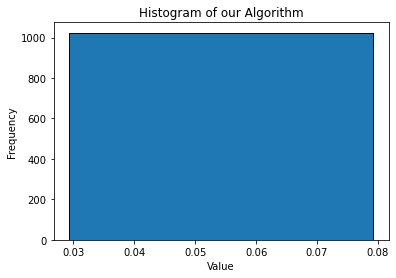

In [136]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data as a NumPy array
data = particle_1

# Define bin size
bin_size = 0.05

# Compute bin edges
bins = np.arange(min(data), max(data) + bin_size, bin_size)

# Plot histogram
plt.hist(data, bins=bins, edgecolor='black')

# Set labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of our Algorithm')

# Show the plot
plt.show()